In [13]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# === Step 1: Load pairwise file just to extract unique tweets ===
df = pd.read_excel("/Users/jessicakamal/la_pairwise_similarity.xlsx")

# === Step 2: Extract all unique tweets ===
tweets = pd.unique(df[['Tweet 1', 'Tweet 2']].values.ravel())

# === Step 3: Convert tweets to TF-IDF vectors ===
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(tweets)

# === Step 4: Apply LSA using Truncated SVD ===
n_components = min(100, X.shape[1])  # You can adjust this as needed
svd = TruncatedSVD(n_components=n_components)
lsa_matrix = svd.fit_transform(X)

# === Step 5: Rank tweets using vector norms in the LSA space ===
scores = np.linalg.norm(lsa_matrix, axis=1)
top_indices = np.argsort(scores)[::-1][:65]

# === Step 6: Generate summary ===
lsa_summary = [tweets[i] for i in top_indices]

# === Step 7: Save to Excel without headers ===
lsa_summary_df = pd.DataFrame(lsa_summary)
lsa_summary_df.to_excel("/Users/jessicakamal/lsa_summary_la.xlsx", index=False, header=False)

print("✅ Traditional LSA summary saved to lsa_summary_la.xlsx")


✅ Traditional LSA summary saved to lsa_summary_la.xlsx


👨 Matched Male Words & Frequencies:
god: 2
men: 2
man: 1

👩 Matched Female Words & Frequencies:
women: 9
mother: 4
woman: 3
she: 2
females: 2
her: 1

🧮 Total Gendered Mentions: 26
📘 Weighted Male Score: 0.192308
📕 Weighted Female Score: 0.807692
📊 Weighted Inclusion Bias Score (female - male): 0.615385
🟣 Summary is biased toward females.


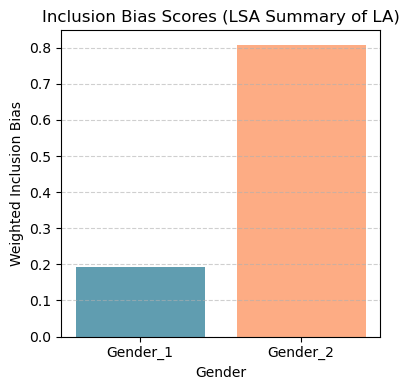

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.tokenize import TreebankWordTokenizer
from collections import Counter

# ✅ Use Treebank tokenizer to avoid punkt issues
tokenizer = TreebankWordTokenizer()

# 🔧 Preprocessing function
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return tokenizer.tokenize(text)

# 📥 Load gender word lists
male_words = pd.read_csv("/Users/jessicakamal/male_list.csv", header=None)[0].str.lower().tolist()
female_words = pd.read_csv("/Users/jessicakamal/female_list.csv", header=None)[0].str.lower().tolist()
male_set = set(male_words)
female_set = set(female_words)

# 📄 Load LSA summary content
summary_df = pd.read_excel("/Users/jessicakamal/lsa_summary_la.xlsx", header=None)
sentences = summary_df[0].dropna().astype(str).tolist()
combined_summary = " ".join(sentences)

# 🧹 Tokenize and count frequencies
tokens = preprocess(combined_summary)
word_freq = Counter(tokens)

# 🧮 Match gendered terms and their frequencies
matched_male = {word: word_freq[word] for word in male_set if word in word_freq}
matched_female = {word: word_freq[word] for word in female_set if word in word_freq}

# 📊 Calculate weighted inclusion bias
total_mentions = sum(matched_male.values()) + sum(matched_female.values())

if total_mentions == 0:
    male_score = female_score = bias_score = 0.0
else:
    male_score = sum(matched_male.values()) / total_mentions
    female_score = sum(matched_female.values()) / total_mentions
    bias_score = female_score - male_score

# 📢 Print frequencies
print("👨 Matched Male Words & Frequencies:")
for word, freq in sorted(matched_male.items(), key=lambda x: -x[1]):
    print(f"{word}: {freq}")

print("\n👩 Matched Female Words & Frequencies:")
for word, freq in sorted(matched_female.items(), key=lambda x: -x[1]):
    print(f"{word}: {freq}")

# 📈 Summary results
print(f"\n🧮 Total Gendered Mentions: {total_mentions}")
print(f"📘 Weighted Male Score: {male_score:.6f}")
print(f"📕 Weighted Female Score: {female_score:.6f}")
print(f"📊 Weighted Inclusion Bias Score (female - male): {bias_score:.6f}")

if bias_score > 0:
    print("🟣 Summary is biased toward females.")
elif bias_score < 0:
    print("🔵 Summary is biased toward males.")
else:
    print("⚪ Summary appears neutral.")

# 📉 Plot results with custom style
plt.figure(figsize=(4, 4))  # Smaller width
plt.bar(["Gender_1", "Gender_2"], [male_score, female_score], color=["#609db0", "#fdac84"])
plt.title("Inclusion Bias Scores (LSA Summary of LA)")
plt.ylabel("Weighted Inclusion Bias")
plt.xlabel("Gender")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
